In [1]:
from __future__ import print_function

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas

## 1. はじめに

最近のデータ分析において，PythonとRは最も人気のある言語です。これらは、それぞれに得意な機能や領分があります。ここでは，PythonとRの両方を使ってデータと格闘する方法を簡単にご紹介します。かなり前からPythonとRを併用しているので、少し偏っているプラクティスであることをご了承ください。

**わたしの個人の意見**としてPythonとRの特徴を以下のように考えています。

| Python                               | R                       |
|--------------------------------------|-------------------------|
| 読みやすさ，書きやすさ，言語の総合力 | 過去の知見の蓄積            |
| 機械学習の充実                   | 統計手法の充実          |
| 実務家ユーザー                   | 研究者          |
| Jupyter Notebook                     | RStudio                 |
| Rより速いことが多い                  | R Markdownによる文書作成 |

これらの認識は、利用するドメインや目的，期限によって変わります。「どちらが○○」みたいな評価は鵜呑みにせずに、試して選べばよいと思います。また、Pythonだけ、Rだけ、あるいは他の言語だけで、仕事が完結するとしても問題はありません。

PythonとRを併用するためには，大きく以下の方法があります。

1. データの共有
2. PythonからRを使う
3. RからPythonを使う
4. Jupyter NotebookでR kernelを使う。

どの場合も、データを中心にして結果に向かって協調する点では同じで、これらを組み合わせて使います。

**制限**

この内容は比較的小規模なデータ（メモリーに入るぐらい）の分析が対象です。

**参考**
* [R vs Python? No! R and Python (and something else)](http://www.datasciencecentral.com/profiles/blogs/r-vs-python-r-and-python-and-something-else)
* [https://www.activestate.com/blog/2016/02/r-vs-python-false-dichotomy]

## 2. データの共有

pandasの登場以来，データフレーム（表形式のデータ）を各種のファイルに落とすことが容易になりました。分析でデータで連携するときはCSVを，分析に疎い人にデータを渡すときはExcelに落とすことが多いのではないでしょうか。


### 2.1. CSV / TSV

CSVはデータの交換，共有で使われる最も基本的な形式ですが、以下の点で面倒なことがあります。

1. 仕様があいまいです。
2. テキストに改行がある場合にうまく扱えないことがあります。
3. データ型（日付，時刻，カテゴリーなど）がわかりません。

TSV（タブ区切り）は2と1（の多く）の問題を解消してくれます。3はRもPythonも"guess"してくれますが、結局型や変換を定義しなければならないでしょう。

In [3]:
csv_pathname='tips.csv'
df = pandas.read_csv(csv_pathname)
#df.to_csv(csv_pathname, encoding='utf-8') #for output

### 2.2. Excel

Excelのよさは誰でもデータをすぐに見て操作できることでしょう。分析に強くない人との共同作業では便利です。たとえば，前処理したデータをExcelに落として，データの閲覧や簡単な分析を分担してもらった上で，高度な分析はこちらで進めるような場合です。

pandasのDataFrameをexcelに保存することは簡単です。うれしいことに改行の入ったテキストもうまく保存してくれます。

In [4]:
excel_pathname='tips.xlsx'
df.to_excel(excel_pathname) 

読み込みも簡単です。

In [5]:
df = pandas.read_excel(excel_pathname)

説明はしませんが、XlsxWriterを使うと，書式設定，結合セル，グラフその他細かい指定が可能です。

Rではtidyverseパッケージを入れておくと便利です。

In [6]:
#おまじない。解説はあとで。
import rpy2
%load_ext rpy2.ipython

In [7]:
%%R -i excel_pathname
library(readxl)
df <- read_excel(excel_pathname)

### 2.3. データベース

分析者や使用ソフトウェアが多い（たとえばTableauが活躍している組織とか）場合、データベースを構築して、キュエリーをかけて分析することも多いでしょう。 

Pythonではpandasが使えます。

In [8]:
import sqlalchemy

engine = sqlalchemy.create_engine('sqlite:///tips.db')
df.to_sql('tips', engine, flavor='sqlite', index=False)
df = pandas.read_sql_table('tips', engine)
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


Rではdplyrが使えます。

### 2.4. feather

featherはデータフレームをファイル保存するためのカラム志向のファイルフォーマットで、今後、使う場面が増えていくと思います。 Apache Arrowの仕様を利用しています。featherの開発者は，Hadley Wickam（ggplot2，plyrやtidy*などを開発したすごい人）と，pandasのWes McKinneyです。現在はR，Python，Juliaのバインディングがあります。高速さ，null/NAやUTF-8文字列の扱いが売りです。サポートしているカラムタイプは以下の通りです。

* A wide range of numeric types (int8, int16, int32, int64, uint8, uint16, uint32, uint64, float, double).
* Logical/boolean values.
* Dates, times, and timestamps.
* Factors/categorical variables that have fixed set of possible values.
* UTF-8 encoded strings.
* Arbitrary binary data.


**featherのインストール**

Pythonではpipで，

    pip install feather-format
    
Rではdevtoolsからのインストールです。

    devtools::install_github("wesm/feather/R")

** 参考 **

* [Feather: fast, interoperable data frame storage](https://github.com/wesm/feather)
* [Feather: A Fast On-Disk Format for Data Frames for R and Python, powered by Apache Arrow by Hadley Wickham](https://blog.rstudio.com/2016/03/29/feather/)

In [9]:
import feather
feather_pathname = 'tips.feather'
feather.write_dataframe(df, feather_pathname)
df = feather.read_dataframe(feather_pathname)

In [10]:
%%R -i feather_pathname
library(feather)
write_feather(df, feather_pathname)
df <- read_feather(feather_pathname)

### 2.5. IPython Extension
### 2.6. RData

IPython extension（rmagic）とRDataについては後で紹介します。

## 3. PythonからRを使う

PythonからRを使うライブラリはRPy2とPypeRがあります。

PypeRはRPy2よりもよい（特にWindowsで）とする情報（ブログ）がありますが，わたしの環境ではうまく動かなかったのでRPy2を使っています。


### 3.1. RPy2の動作要件
RPy2はPython 2.7と>3.3で動作します。Rは3.2+が望ましいようです。RPy2の2.9以降はPython2では動作しないようです。


### 3.2. RPy2のインストールとパッケージ内容

pipでインストールします。

    pip install rpy2 #
    pip install rpy2==2.8.6 #last version for python2 

rpy2には以下のモジュールがあります。

* rpy2.rinterface
* rpy2.robjects
* rpy2.interactive
* rpy2.rpy_classic
* rpy2.rlike


### 3.3.  RPy2の基本

In [11]:
from rpy2.robjects import r

print(r)

platform: x86_64-apple-darwin13.4.0
arch: x86_64
os: darwin13.4.0
system: x86_64, darwin13.4.0
status: 
major: 3
minor: 3.1
year: 2016
month: 06
day: 21
svn rev: 70800
language: R
version.string: R version 3.3.1 (2016-06-21)
nickname: Bug in Your Hair


Pythonの変数varの値を，Rの同名の変数に代入します。

In [12]:
var = 1
r.assign('var', var)

R object with classes: ('integer',) mapped to:
<IntVector - Python:0x11622e3b0 / R:0x7f9ec35a8b58>
[       1]

Rの特殊な変数をプリントします。

In [13]:
pi = r.pi
print(pi)
letters = r.letters
print(letters)
print(r('1+2'))

[ 3.14159265]
['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']
[ 3.]


Rで定義した関数をPythonで実行します。

In [14]:
sqr =r('function(x) x^2')
print(sqr)
print(sqr(2))

function(x) x^2

[1] 4



Pythonではリストのインデックスは0からはじまりますが，Rではインデックスが1からはじまります。

In [15]:
rx = r.seq(1, 5)
rx

R object with classes: ('integer',) mapped to:
<IntVector - Python:0x112558518 / R:0x7f9ec4303d10>
[       1,        2,        3,        4,        5]

In [16]:
x = tuple(rx)
print(x[1])

2


In [17]:
print(rx.rx(1))

[1] 1



**Pythonからdplyrを使う**

dplyrはデータフレームを操作するRの関数です。

データを準備します。

In [18]:
from rpy2.robjects.packages import importr, data

datasets = importr('datasets')                           # importrはRのlibraryに相当
mtcars_env = data(datasets).fetch('mtcars') #　mtcarsをフェッチ
mtcars = mtcars_env['mtcars']                         # 

import rpy2.ipython.html                                    # Rのデータフレームを見やすく表示するために
rpy2.ipython.html.init_printing()

Pythonからdplyrを実行します。

In [19]:
#dplyrで使うDataFrame 
from rpy2.robjects.lib.dplyr import DataFrame 
from rpy2.rinterface import rternalize # 定義した関数がRから呼び出すために， @rternalizeを指定する


@rternalize
def mean_np(x):
    import numpy
    return numpy.mean(x)

from rpy2.robjects import globalenv #関数がRのグローバル変数になるようにする
globalenv['mean_np'] = mean_np

rdf = (DataFrame(mtcars).
         filter('gear>3').
         mutate(powertoweight='hp*36/wt').
         group_by('gear').
         summarize(mean_ptw='mean(powertoweight)',
                             mean_np_ptw='mean_np(powertoweight)'))

rdf

,,gear,mean_ptw,mean_np_ptw
0,1,4.0,1237.12664998,1237.12664998
1,2,5.0,2574.03316393,2574.03316393


返されたデータはRのデータフレームです。これをpandasに変換します。

In [20]:
from rpy2.robjects import pandas2ri

print(type(rdf))
print(type(pandas2ri.ri2py(rdf)))

<class 'rpy2.robjects.lib.dplyr.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


### 3.4. 応用例

Rのtopicmodelsライブラリ（トピックモデル）を使ってLDAを実行します。

データは[gensimのチュートリアル](https://radimrehurek.com/gensim/tut1.html)から。

In [21]:
documents = ["Human machine interface for lab abc computer applications",
              "A survey of user opinion of computer system response time",
              "The EPS user interface management system",
              "System and human system engineering testing of EPS",
              "Relation of user perceived response time to error measurement",
              "The generation of random binary unordered trees",
              "The intersection graph of paths in trees",
              "Graph minors IV Widths of trees and well quasi ordering",
              "Graph minors A survey"]

以下に、さまざまなrpy2の機能を使ったコードを示します。コメントはrpy2の機能にしぼっています。

In [22]:
from rpy2 import robjects
from rpy2.robjects import r
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

class RtopicmodelsLDAModel():
    def __init__(self, documents, num_topics):
        self.documents = documents
        robjects.globalenv['num_topics'] = num_topics               #グローバル変数に代入
        
        lda_pkg = importr('lda')#ldaパッケージを利用
        topicmodels_pkg = importr('topicmodels')#topicmodelsパッケージを利用

        corpus = lda_pkg.lexicalize(documents) #documentsをldaパッケージの形式にする
        # ldaパッケージの形式をtopicmodelsパッケージの形式にして、変数dtmに代入
        # rx2は、Rの”＄”に相当
        robjects.globalenv['dtm'] = topicmodels_pkg.ldaformat2dtm(corpus.rx2('documents'), corpus.rx2('vocab'))
        
        # 関数get_top_wordsを定義、LDAを実行
        robjects.r('''
get_top_words <-  function(r, num_words=10) {
    o <- order(r, decreasing=TRUE);
     top_words <- word_names[o][1:num_words];
};
model <- LDA(dtm, k=num_topics, control=list(verbose=0))
''') 

    def topic_words(self, num_words = 50, threshold=0.005):
        robjects.globalenv['num_words'] = num_words
        robjects.r('''
topic_word_dist <- posterior(model)[[1]]
word_names <- colnames(topic_word_dist);
topic_word_df <- as.data.frame(t(apply(topic_word_dist, 1, get_top_words)))
''')
        topic_words = r['topic_word_df']
        return topic_words
    
model = RtopicmodelsLDAModel(documents, num_topics=5)
model.topic_words()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
1,of,and,user,system,human,iv,response,graph,trees,a
2,interface,system,user,eps,lab,time,a,abc,survey,minors
3,graph,the,trees,minors,computer,response,error,time,generation,random
4,of,trees,system,user,the,human,a,computer,unordered,paths
5,of,system,graph,survey,the,computer,interface,perceived,intersection,time


## 4. rmagic

rmagicとはrpy2を利用してRとのインタラクションをおこなうIPython extensionです。

### rmagicの起動

rmagicはload_extで起動します。

In [23]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


rmagicのラインモードでは，式が評価され，Pythonに値が返されます。

```
%R [-i INPUT] [-o OUTPUT] [-w WIDTH] [-h HEIGHT] [-d DATAFRAME]
       [-u {px,in,cm,mm}] [-r RES] [-p POINTSIZE] [-b BG] [-n]
       [code [code ...]]
```

### %R（ラインマジック）

Rコマンドを実行します。

変数の代入。

In [24]:
%R var <- 1
%R var

array([ 1.])

複数行のRコマンドを一度に実行するときは，";"でつなぎます。

In [25]:
%R X=c(1,4,5,7); sd(X); mean(X)

array([ 4.25])

"-i"でRに変数を渡します。

In [26]:
var = 1
%R　-i var var <- var + 1; print(var)

[1] 2


"-o"でRから変数を取り出します。

In [27]:
%R -o var
print(var)

[ 2.]


### データフレームをRに渡す

seabornのデータセットtipsを使います。このデータセットはRのrshape2ライブラリにもあります。

In [28]:
import seaborn as sns
tips = sns.load_dataset("tips")
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [29]:
%R -i tips head(tips)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,2,2,4,2,2
1,10.34,1.66,1,2,4,2,3
2,21.01,3.50,1,2,4,2,3
3,23.68,3.31,1,2,4,2,2
4,24.59,3.61,2,2,4,2,4
5,25.29,4.71,1,2,4,2,4


### %%R（セルマジック）

%%Rを使うと複数行のRコマンドを実行できます。

GGallyパッケージのggpairsを実行して，変数間の関連を見てみましょう。

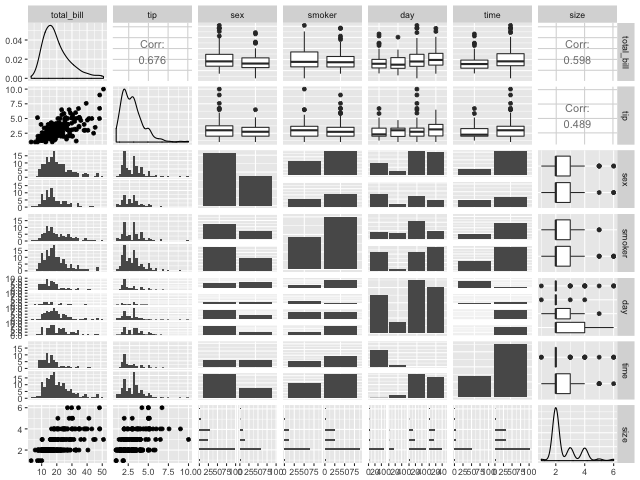

In [30]:
%%R -i tips -w 640 -u px
library(GGally)
pm <- ggpairs(tips)
pm

ちなみにこちらがseabornのペアプロットです。数値変数だけがプロットされます。

In [31]:
sns.pairplot(tips, hue='sex')

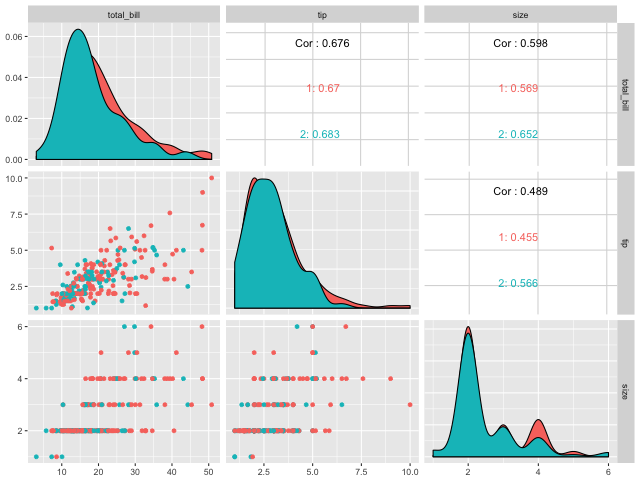

In [32]:
%%R -i tips -w 640 -u px
library(GGally)
library(ggplot2)
pm <- ggpairs(tips, mapping=aes(color=sex), columns=c('total_bill', 'tip', 'size'))
pm

Rのlm関数でtipsデータを回帰してみる。

In [33]:
%%R
fit.all = lm(tip ~ ., data = tips)
summary(fit.all)


Call:
lm(formula = tip ~ ., data = tips)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.8475 -0.5729 -0.1026  0.4756  4.1076 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.590837   0.255829   2.310   0.0218 *  
total_bill   0.094487   0.009601   9.841   <2e-16 ***
sex2         0.032441   0.141612   0.229   0.8190    
smoker2      0.086408   0.146587   0.589   0.5561    
day2         0.162259   0.393405   0.412   0.6804    
day3         0.040801   0.470604   0.087   0.9310    
day4         0.136779   0.471696   0.290   0.7721    
time2       -0.068129   0.444617  -0.153   0.8783    
size         0.175992   0.089528   1.966   0.0505 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.024 on 235 degrees of freedom
Multiple R-squared:  0.4701,	Adjusted R-squared:  0.452 
F-statistic: 26.06 on 8 and 235 DF,  p-value: < 2.2e-16



## 5. RDataの利用

RDataはRのオブジェクトを保存するフォーマットです。

分析用に加工したデータ（変数，データフレームなど）をRDataにまとめて保存しておくと，Rはもちろん，（RPy2経由で）Pythonから取り出して使うことができます。

In [34]:
tips_male = tips[tips.sex == 'Male']         #tipsを加工して分析用データを作成
male_count = len(tips_male)                    #データ長
save_list = ['tips_male', 'male_count']   #保存する変数リスト
rdata_pathname = "tips_project.RData" #RDataのファイル名

RDataをsaveする。

In [35]:
%R -i tips_male,male_count,save_list,rdata_pathname save(list=save_list, file=rdata_pathname)

RDataをloadする。データフレームはpandasに変換されている。

In [36]:
% R -i rdata_pathname -o tips_male load(rdata_pathname)
type(tips_male)

pandas.core.frame.DataFrame

## 6. RからPythonを呼び出す

くわしくは説明しませんが、RからPythonを呼び出すこともできます。

* reticulate https://cran.r-project.org/web/packages/reticulate/index.html
    * http://qiita.com/nakamichi/items/28c7f578a558e13ebc52
* PythonInR https://pythoninr.bitbucket.io/
* R Markdown
    http://rmarkdown.rstudio.com/authoring_knitr_engines.html

RStudio製のreticulateはRPy2同様に完成度が高いと思います。

R Markdownは、MarkdownにRのプログラムを埋め込んで、レンダリング結果としてPDFやTeXやMicrosoft Wordを出力するユーティリティです。現在はPythonをはじめさまざまな言語が利用できます。



## 8. データ交換での注意点

### 欠損値の取扱

pandasはRに比べてnulll / NA(Not Available) / NaN (Not a Number) の扱いが適当です。欠損値の扱いを決めて、Pythonで加工（フィルター，置換など）してから、Rに渡すのがよいでしょう。それぞれで記述統計を取ってチェックすることも必要です。

参考: https://www.oreilly.com/learning/handling-missing-data

### pandasのobject型

なるべくobjectではなく，int/floatで扱われるようにしておくとトラブルが少なくなります。

### カテゴリー

pandasのcategorical，Rのfactorは相互変換されるので便利です。

### バージョン

バックエンドでPython / Rを呼び出すとき、バージョンを忘れてしまうことがあります。言語と、使用するライブラリのバージョンを把握しておきます。

## 9. まとめ

WesとHadleyが組んだように，PythonとRはなかよくしようぜ。